In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import collections
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.image as mpimg
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import gc

# Get statistics over all matching pipelines

In [345]:

#####################
### FUNCTIONS
#####################
def score_function(group):
    """The scorefunction S(Theta)"""
    # Belohne Qualität / Smooth
    # lambda  * 0.5 * (t1 + t2)
    # t1 = tanh(0.5 * tanh(A) + tanh(B*B))
    # t2 = tanh(0.5 * tanh(C) + tanh(D*D))
    
    # Get lambda factor. Note: lambda is reserved word in python
    lambdaa = group[['lambda']].values.reshape(-1, 1)
    
    A = group.matchability.values.reshape(-1, 1)
    B = group.accuracy_matches.values.reshape(-1, 1)
    C = group.inlier_ratio.values.reshape(-1, 1)
    D = group.accuracy_inliers.values.reshape(-1, 1)
    
    t1 = np.tanh(0.5 * np.tanh(A) + np.tanh(B*B))
    t2 = np.tanh(0.5 * np.tanh(C) + np.tanh(D*D))
    
    values = np.hstack([t1, t2])
    values *= lambdaa
    
    # Build mean for each column
    mean_values = np.mean(values, axis=0)

    # Build mean of means to get score
    score = np.mean(mean_values)
    
    return score

def create_scoremap(
    df:pd.DataFrame,
    desc2row:Dict,
    det2col:Dict,
    filters:Dict={}) -> np.array:
    """Creates a single scoremap for ALL triplets 
    (kp_thresh, descriptor_name, detector_name)"""
    
    descriptor_names = sorted(df.descriptor_name.unique())
    detector_names = sorted(df.detector_name.unique())
    scoremap = np.full((len(descriptor_names), len(detector_names)), np.nan)
    
    # Filter df for each key-value pair in filters
    _df = df
    for k, v in filters.items():
        _df = _df[df[k] == v]

    # Group by descriptors and detectors
    _g = _df.groupby(['descriptor_name', 'detector_name'])

    for gname, group in _g:
        i = desc2row[gname[0]]
        j = det2col[gname[1]]
        
        score = score_function(group)

        scoremap[i][j] = score
    
    return scoremap


def find_best_matching_method_by_avg_score(
    evaluations:List[str],
    eval_dict:Dict,
    desc2row:Dict,
    det2col:Dict,
    filters:Dict={}) -> Tuple[np.array, np.array, np.array]:
    """Returns labels and avg score for each matching method in
    descending order as well as their sorting indices."""
    scoremaps = []
    labels = []
    for evaluation in evaluations:
        df = get_dataframe(evaluation, eval_dict)

        scoremaps.append(create_scoremap(df, desc2row, det2col, filters=filters))
        labels.append(eval_dict[evaluation]['label'])

    # Convert to np.array
    scoremaps = np.array(scoremaps)
    labels = np.array(labels)

    # Build average score for an evaluation
    avg_scores = np.array([np.nanmean(x) for x in scoremaps])

    # sort by avg_scores
    idx_descending = avg_scores.argsort()[::-1]
    avg_scores = avg_scores[idx_descending]
    labels = labels[idx_descending]
    
    return labels, avg_scores, idx_descending

def get_dataframe(evaluation_method:str, eval_dict:Dict) -> pd.DataFrame:
    file_name = eval_dict[evaluation_method]['file_name'] + '.csv'
    
    # Load data
    df = pd.read_csv(os.path.join(data_dir, file_name), sep=',', comment='#')
    
    return df

def save_figure(
  path_output:str,
  fig_name:str, 
  figure: mpl.figure.Figure,
  dpi:int=300) -> None:

    if not os.path.exists(path_output):
        os.makedirs(path_output, exist_ok=True)

    f_out = os.path.join(path_output, fig_name)
  
    figure.savefig(f_out, dpi=dpi)
#####################
### SETTINGS
#####################
desc2row = {
    'doap': 0,
    'lift': 1,
    'sift': 2,
    'superpoint': 3,
    'tfeat': 4
}

det2col = {
    'lift': 0,
    'sift': 1,
    'superpoint': 2,
    'tcovdet': 3,
    'tilde': 4
}


id2name = {
    'sift': 'SIFT',
    'lift': 'LIFT',
    'tilde': 'TILDE',
    'superpoint': 'SuperPoint',
    'tcovdet': 'TCovDet',
    'tfeat': 'TFeat',
    'doap': 'DOAP',
    'v_set_01': 'Set 1',
    'v_set_02': 'Set 2',
    'v_set_03': 'Set 3',
    'v_set_04': 'Set 4',
    'v_set_05': 'Set 5',
    'v_set_06': 'Set 6',
    'v_set_07': 'Set 7',
    'v_set_08': 'Set 8',
    'v_set_09': 'Set 9',
    'v_set_10': 'Set 10',
    'v_set_11': 'Set 11',
    'v_set_12': 'Set 12',
    'v_set_13': 'Set 13'
}

color_scheme = {
  'sift': '#1f77b4',
  'lift': '#ff7f0e',
  'tilde': '#2ca02c',
  'superpoint': '#d62728',
  'tcovdet': '#9467bd',
  'tfeat': '#2ca02c',
  'doap': '#9467bd'
}

keypoint_threshold_colors = ['skyblue', 'purple', 'crimson']

marker_scheme = {
  'sift': 'o',
  'lift': 'x',
  'tilde': 'd',
  'superpoint': '^',
  'tcovdet': 'h',
  'tfeat': '*',
  'doap': 'p'
}

line_styles = ['-', '-.', ':', '--']

eval_dict = {
    'nn2way': {
        'file_name': 'descriptor_matching_eisert_nn2way',
        'label': 'NN2WAY'
    },
    'bf_ratio': {
        'file_name': 'descriptor_matching_eisert_bf_ratio',
        'label': 'BF + Ratio'
    },
    'bf': {
        'file_name': 'descriptor_matching_eisert_bf',
        'label': 'BF'
    },
    'flann': {
        'file_name': 'descriptor_matching_eisert_flann',
        'label': 'FLANN'
    },
    'flann_ratio': {
        'file_name': 'descriptor_matching_eisert_flann_ratio',
        'label': 'FLANN + Ratio'
    },
    'nn2way_no_normalization': {
        'file_name': 'descriptor_matching_eisert_nn2way_no_normalization',
        'label': 'NN2WAY\n(no normalization)'
    },
    'bf_ratio_no_normalization': {
        'file_name': 'descriptor_matching_eisert_bf_ratio_no_normalization',
        'label': 'BF + Ratio\n(no normalization)'
    },
    'bf_no_normalization': {
        'file_name': 'descriptor_matching_eisert_bf_no_normalization',
        'label': 'BF\n(no normalization)'
    },
    'flann_no_normalization': {
        'file_name': 'descriptor_matching_eisert_flann_no_normalization',
        'label': 'FLANN\n(no normalization)'
    },
    'flann_ratio_no_normalization': {
        'file_name': 'descriptor_matching_eisert_flann_ratio_no_normalization',
        'label': 'FLANN + Ratio\n(no normalization)'
    },
}


# nn2way | bf | bf_ratio | flann | flann_ratio | nn2way_no_normalization | bf_no_normalization | 
# bf_ratio_no_normalization | flann_no_normalization | flann_ratio_no_normalization

evaluations = ['nn2way', 'bf', 'bf_ratio', 'flann', 'flann_ratio', 'nn2way_no_normalization', 
               'bf_no_normalization',  'bf_ratio_no_normalization', 'flann_no_normalization', 
               'flann_ratio_no_normalization']


data_dir = '/home/mizzade/Workspace/diplom/outputs/eval_matching_pipeline'
output_dir = '/home/mizzade/Workspace/diplom/outputs/eval_matching_pipeline/'
fout_name = 'comparison.csv'

#####################
### MAIN
#####################
save_outputs = False

# Build df from all Evaluations
df_list = []

for evaluation in evaluations:
    
    # Load data
    df = get_dataframe(evaluation, eval_dict)
    df_list.append(df)


df = pd.concat(df_list, ignore_index=True)

matching_methods = sorted(df.matching_method.unique())
descriptor_names = sorted(df.descriptor_name.unique())
detector_names = sorted(df.detector_name.unique())
set_names = sorted(df.set_name.unique())
kpts_thresholds = sorted(df.kpts_threshold.unique())

Finde das Verfahren mit den im Durchschnitt besten Werten für alle Detektor-Deskriptor Kombinationen

In [3]:
df.shape, df.columns

((45045, 23),
 Index(['collection_name', 'set_name', 'kpts_threshold', 'descriptor_name',
        'detector_name', 'matching_method', 'desc_distance_threshold',
        'ransac_threshold', 'ransac_confidence', 'num_kpts_i', 'num_kpts_j',
        'max_num_matches', 'num_matches', 'matchability', 'accuracy_matches',
        'mse_matching', 'max_num_inliers', 'num_inliers', 'inlier_ratio',
        'avg_distance', 'mse_estimation', 'lambda', 'accuracy_inliers'],
       dtype='object'))

In [4]:
def custom_score_function(row):
    """ Gets a pandas dataframe row, evaluates score"""
    
    R1 =  0.5 * np.tanh(row['matchability'])
    A1 = np.tanh(row['accuracy_matches'] ** 2)
    
    R2 = 0.5 * np.tanh(row['inlier_ratio'])
    A2 = np.tanh(row['accuracy_inliers'])
    
    score = 0.5 * row['lambda'] * (np.tanh(R1 + A1) + np.tanh(R2 + A2))
    
    return score

In [5]:
# Um die beste Matching Strategie zuer erhalten:
# Errechne die Punktzahlen für jedes Bilderset UNABHÄNGIG VON 
# - DETEKTOR
# - DESKRIPTOR
# - KPTHRESH

# 1. Group Dataframe only by matching method
g_by_mm = df.groupby(['matching_method'])

# 2. Score each row in dataframe
scores_by_mm = g_by_mm.apply(custom_score_function) # Returns pandas series


# # 3. Compute mean, min, max, and std of scores
mm_mean = scores_by_mm.groupby('matching_method').mean().rename('mean')
mm_std = scores_by_mm.groupby('matching_method').std().rename('std')
mm_min = scores_by_mm.groupby('matching_method').min().rename('min')
mm_max = scores_by_mm.groupby('matching_method').max().rename('max')


# # 4. Create dataframe for it
df_by_mm = pd.concat([mm_mean, mm_std, mm_min, mm_max], axis=1)

# 5. Sort by mean score
df_by_mm.sort_values(by=['mean'], ascending=False, inplace=True)
df_by_mm.round(3)

,mean,std,min,max
matching_method,,,,
flann,0.401,0.188,0.0,0.700
bf,0.399,0.193,0.0,0.707
nn2way,0.392,0.196,0.0,0.711
bf_ratio,0.348,0.261,0.0,0.714
flann_ratio,0.347,0.259,0.0,0.713
nn2way_no_normalization,0.275,0.118,0.0,0.637
bf_no_normalization,0.218,0.200,0.0,0.699
flann_no_normalization,0.215,0.200,0.0,0.700
flann_ratio_no_normalization,0.147,0.207,0.0,0.719


In [6]:
# Die beste Matching Methode lautet bestMM
bestMM = df_by_mm.iloc[0].name
print('Die beste Matching Strategie ist {}.'.format(bestMM))

# Betrachte im Folgenden nur Werte fuer die beste Matching Methode betsMM
df_bestMM = df[df.matching_method == bestMM]

Die beste Matching Strategie ist flann.


Finde nun die Durchschnittswertungen aller Detektor/Deskriptor Kombinationen unabhängig von der Anzahl geforderter Keypoints $\tau_{kp}$ bei der Verwendung von FLANN als Matching Verfahren.

In [7]:
# Um die beste Kombination aus Detektor und Deskriptor unabhängig von
# KP_Thresh zu erhalten, errechne die Durchschnittliche Punktzahl 
# für die bestMM für alle Kombinationen  über alle KP_THRESH

# 1. Group Dataframe only by by combinations of detector and descriptor
#g_by_ddcombi = df.groupby(['detector_name', 'descriptor_name'])
g_by_ddcombi = df_bestMM.groupby(['detector_name', 'descriptor_name'])

# 2. Score each row in dataframe
scores_by_ddcombi = g_by_ddcombi.apply(custom_score_function) # Returns pandas series

# 3. Compute mean, min, max, and std of scores
ddcombi_mean = scores_by_ddcombi.groupby(['detector_name', 'descriptor_name']).mean().rename('mean')
ddcombi_std = scores_by_ddcombi.groupby(['detector_name', 'descriptor_name']).std().rename('std')
ddcombi_min = scores_by_ddcombi.groupby(['detector_name', 'descriptor_name']).min().rename('min')
ddcombi_max = scores_by_ddcombi.groupby(['detector_name', 'descriptor_name']).max().rename('max')

# # 4. Create dataframe for it
df_by_ddcombi = pd.concat([ddcombi_mean, ddcombi_std, ddcombi_min, ddcombi_max], axis=1)
df_by_ddcombi

# 5. Sort by mean score
df_by_ddcombi.sort_values(by=['mean'], ascending=False, inplace=True)
df_by_ddcombi.round(3)

mean    std    min    max
detector_name descriptor_name                            
superpoint    lift             0.597  0.018  0.558  0.623
lift          lift             0.576  0.107  0.124  0.683
tilde         lift             0.556  0.127  0.085  0.640
superpoint    sift             0.523  0.037  0.458  0.601
lift          sift             0.520  0.132  0.111  0.685
superpoint    tfeat            0.512  0.036  0.426  0.578
              superpoint       0.478  0.094  0.304  0.632
tilde         sift             0.457  0.128  0.063  0.638
              tfeat            0.429  0.104  0.063  0.559
lift          tfeat            0.423  0.109  0.079  0.649
sift          lift             0.406  0.243  0.008  0.652
              sift             0.401  0.250  0.007  0.700
superpoint    doap             0.376  0.028  0.315  0.429
sift          tfeat            0.374  0.231  0.007  0.690
lift          doap             0.333  0.057  0.089  0.385
tilde         doap             0.323  0.074  0.050  0.405
tcovdet       lift             0.322  0.217  0.054  0.669
              tfeat            0.227  0.154  0.036  0.531
              sift             0.212  0.153  0.000  0.487
              doap             0.189  0.130  0.029  0.411
sift          doap             0.180  0.167  0.000  0.406

In [8]:
# Die beste Detektor/Deskriptor Kombination lautet bestDD
bestDD = df_by_ddcombi.iloc[0].name
print('Die Detektor/Deskriptor Kombination ist {}.'.format(bestDD))

Die Detektor/Deskriptor Kombination ist ('superpoint', 'lift').


In [9]:
# Bewertung der Detektoren unabhängig vom Deskriptor
df_by_ddcombi.groupby('detector_name') \
    .mean() \
    .sort_values(by=['mean'], ascending=False) \
    .round(3)

,mean,std,min,max
detector_name,,,,
superpoint,0.497,0.043,0.412,0.573
lift,0.463,0.101,0.101,0.601
tilde,0.441,0.108,0.065,0.561
sift,0.340,0.223,0.005,0.612
tcovdet,0.237,0.164,0.030,0.524


In [10]:
# Bewertung der Deskriptoren unabhängig vom Detektor

df_by_ddcombi.groupby('descriptor_name') \
    .mean() \
    .sort_values(by=['mean'], ascending=False) \
    .round(3)

,mean,std,min,max
descriptor_name,,,,
lift,0.491,0.143,0.166,0.653
superpoint,0.478,0.094,0.304,0.632
sift,0.423,0.140,0.128,0.622
tfeat,0.393,0.127,0.122,0.601
doap,0.280,0.091,0.097,0.407


Wir untersuchen im Folgendene nur noch die folgenden Detektor/Deskriptor Kombinationen:
 - 1) SuperPoint/LIFT
 - 2) LIFT/LIFT
 - 3) SuperPoint/SuperPoint
 - 4) SIFT/SIFT

In [11]:
df_bestDD = df_bestMM[
    ((df_bestMM.detector_name == 'superpoint') & (df_bestMM.descriptor_name == 'lift')) |
    ((df_bestMM.detector_name == 'lift') & (df_bestMM.descriptor_name == 'lift')) |
    ((df_bestMM.detector_name == 'superpoint') & (df_bestMM.descriptor_name == 'superpoint')) |
    ((df_bestMM.detector_name == 'sift') & (df_bestMM.descriptor_name == 'sift')) 
]

df_bestDD.head()

,collection_name,set_name,kpts_threshold,descriptor_name,detector_name,matching_method,desc_distance_threshold,ransac_threshold,ransac_confidence,num_kpts_i,...,matchability,accuracy_matches,mse_matching,max_num_inliers,num_inliers,inlier_ratio,avg_distance,mse_estimation,lambda,accuracy_inliers
12300,eisert,v_set_01,1000,lift,lift,flann,0.7,3,0.99,1000,...,0.618000,0.808298,3.814126,618,15,0.024272,0.549905,0.177134,1.0000,0.816698
12301,eisert,v_set_01,5000,lift,lift,flann,0.7,3,0.99,5000,...,0.570200,0.832313,6.940565,2851,20,0.007015,0.776704,0.180942,1.0000,0.741099
12302,eisert,v_set_01,10000,lift,lift,flann,0.7,3,0.99,9661,...,0.540383,0.890980,7.051602,5105,21,0.004114,0.765938,0.172334,0.9447,0.744687
12306,eisert,v_set_01,1000,lift,superpoint,flann,0.7,3,0.99,1000,...,0.586000,0.796582,3.872185,586,34,0.058020,1.300871,0.195452,1.0000,0.566376
12307,eisert,v_set_01,5000,lift,superpoint,flann,0.7,3,0.99,5000,...,0.554400,0.826744,7.144493,2772,21,0.007576,0.819371,0.192433,1.0000,0.726876


In [12]:
# 1. Group Dataframe only by sets and  combinations of detector and descriptor
#g_by_set = df_bestDD.groupby(['set_name', 'detector_name', 'descriptor_name'])
g_by_set = df_bestDD.groupby(['detector_name', 'descriptor_name', 'set_name'])
g_by_set.groups

# # 2. Get mean values for  matchability, match accuracy, inlier ratio and inlier accuracy over three kpthresh values
df_ddscores_by_set = g_by_set.aggregate(np.nanmean)
df_ddscores_by_set.head()

kpts_threshold  \
detector_name descriptor_name set_name                   
lift          lift            v_set_01     5333.333333   
                              v_set_02     5333.333333   
                              v_set_03     5333.333333   
                              v_set_04     5333.333333   
                              v_set_05     5333.333333   

                                        desc_distance_threshold  \
detector_name descriptor_name set_name                            
lift          lift            v_set_01                      0.7   
                              v_set_02                      0.7   
                              v_set_03                      0.7   
                              v_set_04                      0.7   
                              v_set_05                      0.7   

                                        ransac_threshold  ransac_confidence  \
detector_name descriptor_name set_name                                        
lift          lift            v_set_01               3.0               0.99   
                              v_set_02               3.0               0.99   
                              v_set_03               3.0               0.99   
                              v_set_04               3.0               0.99   
                              v_set_05               3.0               0.99   

                                         num_kpts_i   num_kpts_j  \
detector_name descriptor_name set_name                             
lift          lift            v_set_01  5220.333333  5149.000000   
                              v_set_02  5220.333333  5266.000000   
                              v_set_03  5256.333333  5292.333333   
                              v_set_04  5277.000000  5268.666667   
                              v_set_05  5303.000000  5286.666667   

                                        max_num_matches  num_matches  \
detector_name descriptor_name set_name                                 
lift          lift            v_set_01      5149.000000  2858.000000   
                              v_set_02      5220.333333  2246.333333   
                              v_set_03      5256.333333  2968.333333   
                              v_set_04      5268.666667  3039.333333   
                              v_set_05      5286.666667  3558.666667   

                                        matchability  accuracy_matches  \
detector_name descriptor_name set_name                                   
lift          lift            v_set_01      0.576194          0.843864   
                              v_set_02      0.443628          0.780888   
                              v_set_03      0.570168          0.604150   
                              v_set_04      0.590903          0.751645   
                              v_set_05      0.677682          0.790890   

                                        mse_matching  max_num_inliers  \
detector_name descriptor_name set_name                                  
lift          lift            v_set_01      5.935431      2858.000000   
                              v_set_02      7.019149      2246.333333   
                              v_set_03     14.211307      2968.333333   
                              v_set_04      9.401705      3039.333333   
                              v_set_05      8.719012      3558.666667   

                                        num_inliers  inlier_ratio  \
detector_name descriptor_name set_name                              
lift          lift            v_set_01    18.666667      0.011800   
                              v_set_02    16.000000      0.013017   
                              v_set_03    19.000000      0.011249   
                              v_set_04    17.666667      0.009881   
                              v_set_05    17.333333      0.009015   

                                        avg_distance  mse_estimation  \
detector_name descriptor_name set_name  

### Plot results

In [370]:
# Draw lineplot
def draw_lineplot(ax, data:np.array, options:Dict):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    _defaults = {
        'xticks': [],
        'yticks': [],
        'xticklabels': [],
        'yticklabels': [],
        'xlabel': '',
        'ylabel': '',
        'colors': plt.rcParams['axes.prop_cycle'].by_key()['color'],
        'linewidth': 2,
        'linealpha': 1,
        'linemarkers': list(mpl.markers.MarkerStyle.markers)[2:],
        'linemarkersize': 2,
        'linelabels': None
        
    }
    settings = {**_defaults, **options}
    
    # Roteate xtick labels
    ax.tick_params(axis='x', which='both', labelrotation=30)
    ax.grid(linestyle=':')
    
    ax.set_xticks(settings['xticks'])
    
    
    ax.set_xticklabels(settings['xticklabels'], fontsize=14)

    ax.set_xlabel(settings['xlabel'])
    ax.set_ylabel(settings['ylabel'], fontsize=14)
    
    ax.set_title(settings['title'], fontsize=16)
    
    # Plot each row in data
    for i, row in enumerate(data):
       
        linelabel = settings['linelabels'][i]
        color = settings['colors'][i]
        linestyle = ':'
        linewidth = settings['linewidth']
        linealpha = settings['linealpha']
        linemarkersize = settings['linemarkersize']
        linemarker = settings['linemarkers'][i]
        
        # Draws dashed line
        ax.plot(
            data[i,:],
            linestyle=linestyle,
            linewidth=linewidth,
            alpha=linealpha,
            color=color)
    
        # only draws markers, by setting dashes to 1000
        ax.plot(
            settings['xticks'],
            data[i, :],
            color=color,
            marker=linemarker,
            markersize=linemarkersize,
            label=linelabel,
            dashes=(5, 1000))        

# Draw RECTANGLES
def draw_boxes(
    ax, 
    data:np.array, 
    options:Dict={}):
    
    _defaults = {
        'xticks': [],
        'yticks': [],
        'xticklabels': [],
        'yticklabels': [],
        'xlabel': '',
        'ylabel': '',
        'cmap': plt.rcParams['image.cmap'],
        'fontcolor': 'black',
        'fontsize': 14,
        'vmin': 0,
        'vmax': 1,
        'value_formatter': '{:.2f}',
        'data_normalized': None
    }
        
    settings = {**_defaults, **options}
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Roteate xtick labels
    ax.tick_params(axis='x', which='both', labelrotation=30)
    
    ax.set_xticks(settings['xticks'])
    ax.set_yticks(settings['yticks'])
    
    
    ax.set_xticklabels(settings['xticklabels'], fontsize=14)
    ax.set_yticklabels(settings['yticklabels'], fontsize=14)

    ax.set_xlabel(settings['xlabel'])
    ax.set_ylabel(settings['ylabel'])

    # If you pass normalized data use that for coloring.
    data_normalized = data \
        if settings['data_normalized'] is None \
        else settings['data_normalized']
    
    # Plot data map
    ax.imshow(data_normalized, 
              cmap=settings['cmap'], 
              vmin=settings['vmin'], 
              vmax=settings['vmax'])
    
    # Plot data values
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data[i][j]
            
            t = settings['value_formatter'].format(value)
            text = ax.text(j, i, t, 
                   ha='center', 
                   va='center', 
                   color=settings['fontcolor'],
                   fontsize=settings['fontsize']);

In [323]:
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap_good = mpl.colors.LinearSegmentedColormap.from_list("", ['tomato', 'gold', 'forestgreen'], 10)
cmap_bad = mpl.colors.LinearSegmentedColormap.from_list("", ['forestgreen', 'gold', 'tomato'], 10)
eval_ids = ['matchability', 'accuracy_matches', 'inlier_ratio', 
            'accuracy_inliers', 'lambda', 'max_num_inliers', 
            'num_inliers', 'avg_distance', 'mse_estimation']
eval_names = ['Matchabililty', 'Genauigkeit der Matches', 
              'Inlier-Rate', 'Genauigkeit der Inlier', 
              'Lambda', 'Anzahl an Matches', 'Anzahl der Inliers',
             'Durchschnittliche Distanz zur Epipolarlinie',
             'Mean Squared Error']
set2name = {
    'v_set_01': 'Set 1',
     'v_set_02': 'Set 2',
     'v_set_03': 'Set 3',
     'v_set_04': 'Set 4',
     'v_set_05': 'Set 5',
     'v_set_06': 'Set 6',
     'v_set_07': 'Set 7',
     'v_set_08': 'Set 8',
     'v_set_09': 'Set 9',
     'v_set_10': 'Set 10',
     'v_set_11': 'Set 11',
     'v_set_12': 'Set 12',
     'v_set_13': 'Set 13'
}
markers = list(mpl.markers.MarkerStyle.markers)

model2name = {
    'superpoint': 'SuperPoint',
    'lift': 'LIFT',
    'sift': 'SIFT'
}

# The detector/descriptor combinations to evaluate

dd_combinations = [
    ('superpoint', 'lift'),
    ('lift', 'lift'),
    ('superpoint', 'superpoint'),
    ('sift', 'sift')
]

dd_combination_names = ['SuperPoint\n+LIFT', 'LIFT\n+LIFT', 'SuperPoint\n+SuperPoint', 'SIFT\n+SIFT']

data = df_ddscores_by_set[eval_ids]
data = data.unstack(level=2) # Reset set_name to become a column

set_labels = [set2name[x] for x in data.columns.levels[1]]

In [342]:
def _plot(data:np.array, 
          options_lineplot:Dict=[], 
          options_rectplot:Dict=[]):
    plt.rcParams['figure.figsize'] = [16, 12]
    fig, axes = plt.subplots(2, 1)
    
    # LINEPLOT
    ax=axes[0]
    draw_lineplot(ax, data, options_lineplot)
    ax.legend()
#     ax.legend(loc='lower right', bbox_to_anchor=(-0.05, 0))
    
    # RectPlot
    ax=axes[1]
    draw_boxes(ax, data, options_rectplot)
    return fig, axes

In [312]:
def plot_stats2(
    df, 
    dd_combinations:List[Tuple[str, str]],
    value_label:str,
    options_data:Dict = {},
    options_lineplot:Dict = {},
    options_rectplot:Dict = {}):
    
    #  1. Convert pandas df to simple numpy array.
    #  2. Call _plot
    
    # 1.1 Sort data by dd_combination
    
    if isinstance(df, pd.DataFrame):
        _data = []
        for detector_name, descriptor_name in dd_combinations:
            _data.append(df[value_label].loc[detector_name, descriptor_name].values)
        _data = np.vstack(_data)
    else:
        _data = df
    
    if options_data.get('convert_to', None):
        _data = _data.astype(options_data['convert_to'])
    
    return _plot(_data, options_lineplot, options_rectplot)

In [347]:
outpath = os.path.join(output_dir, 'graphs')

## Lambda

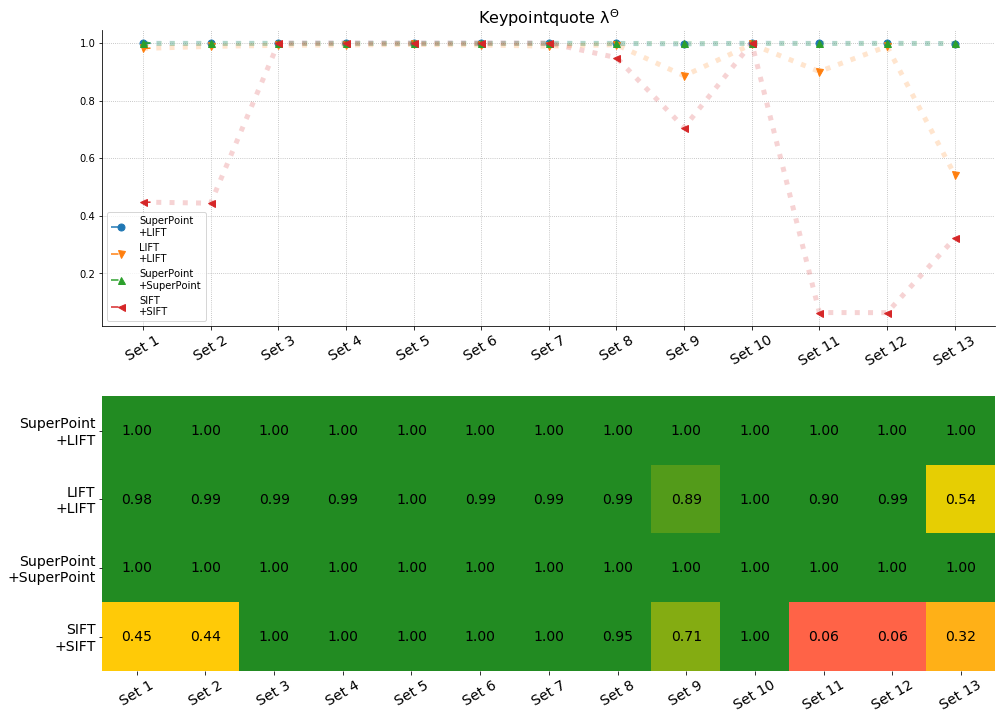

In [374]:
fig, _ = plot_stats2(data, dd_combinations, 'lambda', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Keypointquote $\mathrm{\lambda}^{\Theta}$'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});

save_figure(outpath, 'keypointquote_lambda.png', fig)

# Matchability

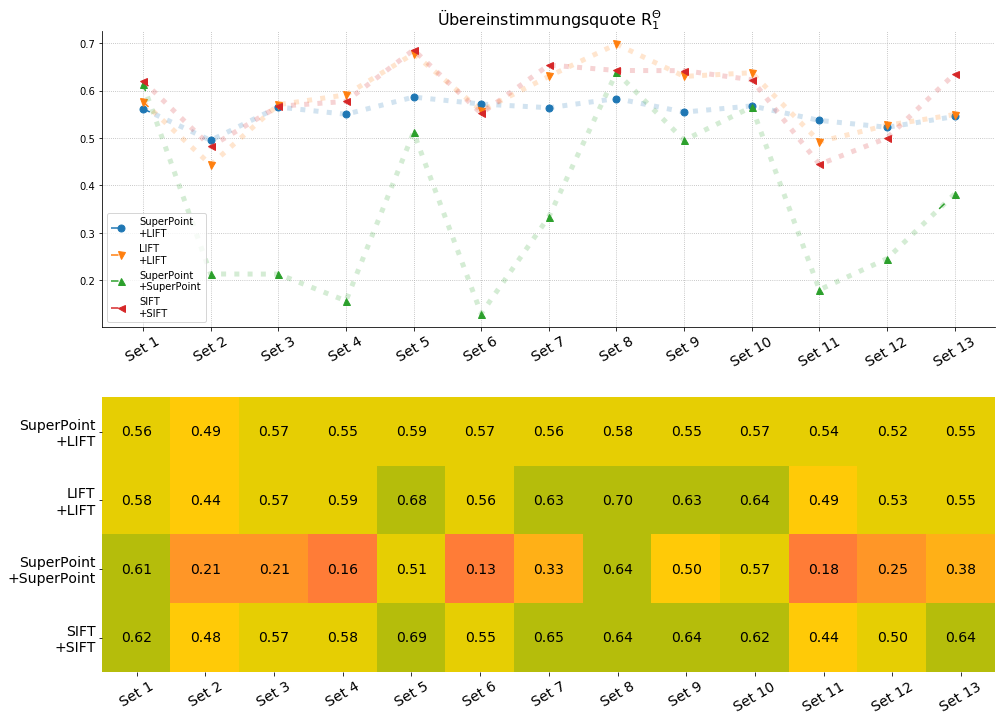

In [375]:
fig, _ = plot_stats2(data, dd_combinations, 'matchability', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Übereinstimmungsquote $\mathrm{R}_{1}^{\Theta}$'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});
save_figure(outpath, 'matchability_r1.png', fig)

## Genauigkeit Matches

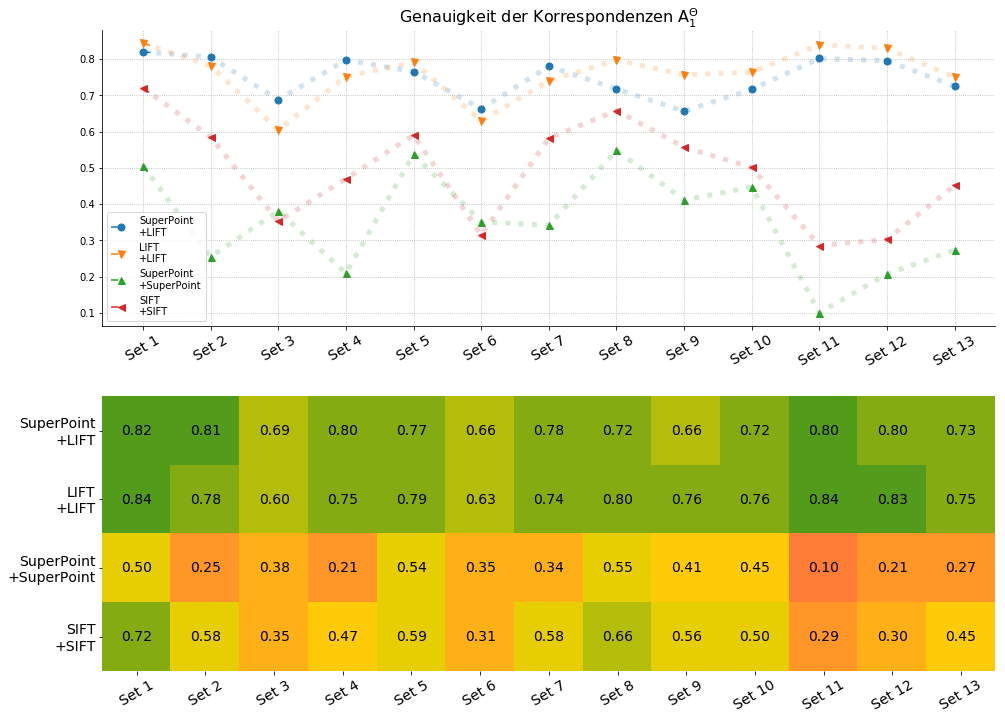

In [376]:
fig, _ = plot_stats2(data, dd_combinations, 'accuracy_matches', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Genauigkeit der Korrespondenzen $\mathrm{A}_{1}^{\Theta}$'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});
save_figure(outpath, 'korrespondenzgenauigkeit_a1.png', fig)

## Inlier-Rate
- Verhältnis von Anzahl der Inliers zu Anzahl der Matches

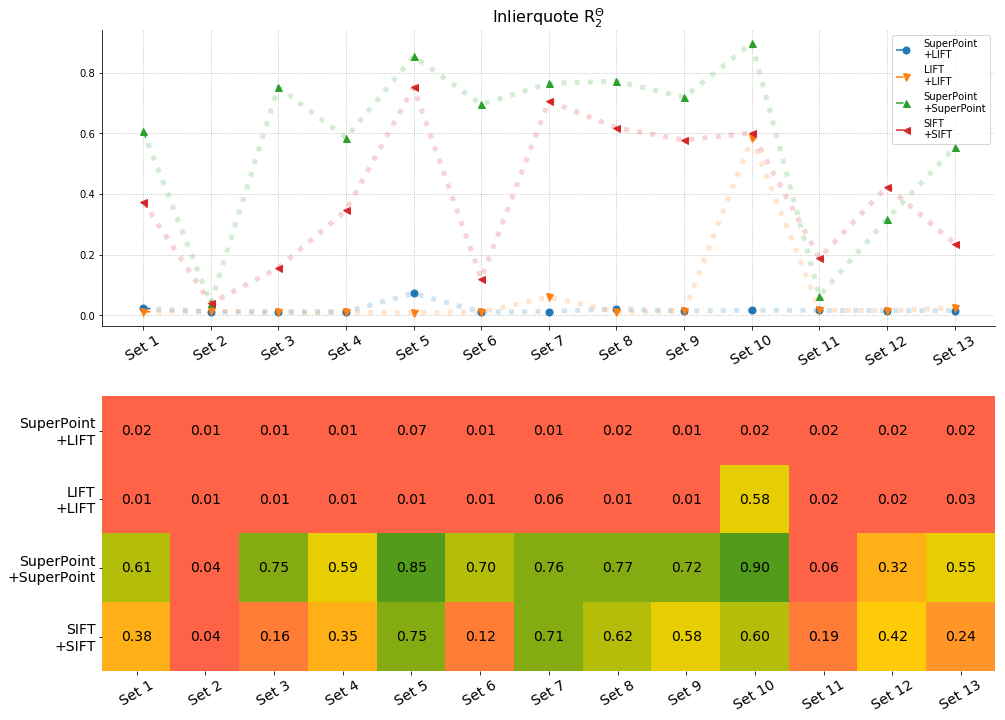

In [377]:
fig, _ = plot_stats2(data, dd_combinations, 'inlier_ratio', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Inlierquote $\mathrm{R}_{2}^{\Theta}$'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});
save_figure(outpath, 'inlierquote_r2.png', fig)

## Inlier Genauigkeit

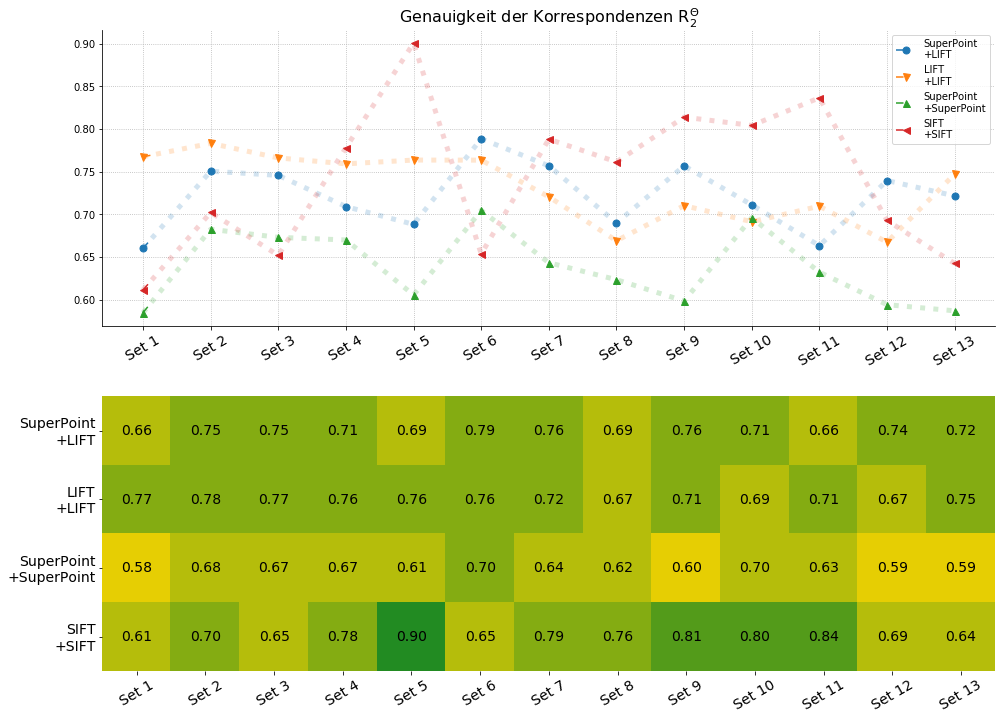

In [378]:
fig, _ = plot_stats2(data, dd_combinations, 'accuracy_inliers', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Genauigkeit der Korrespondenzen $\mathrm{R}_{2}^{\Theta}$'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});
save_figure(outpath, 'inlierqualität_a2.png', fig)

### Durchschnittliche Distanz zur Epipolarlinie

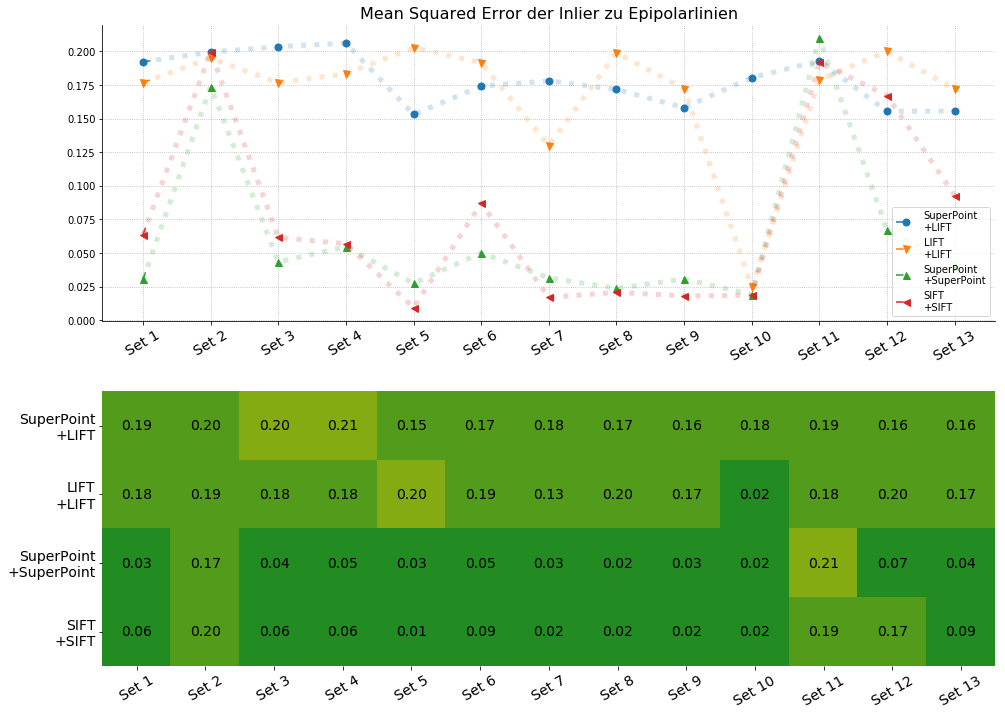

In [379]:
fig, _ = plot_stats2(data, dd_combinations, 'mse_estimation', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Mean Squared Error der Inlier zu Epipolarlinien'
}, options_rectplot={
    'cmap': cmap_bad,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});
save_figure(outpath, 'mean_squared_error_epipolardistances.png', fig)

## Max Num Inliers  ( = Anzahl der Matches)
- absolute Anzahl an Matches

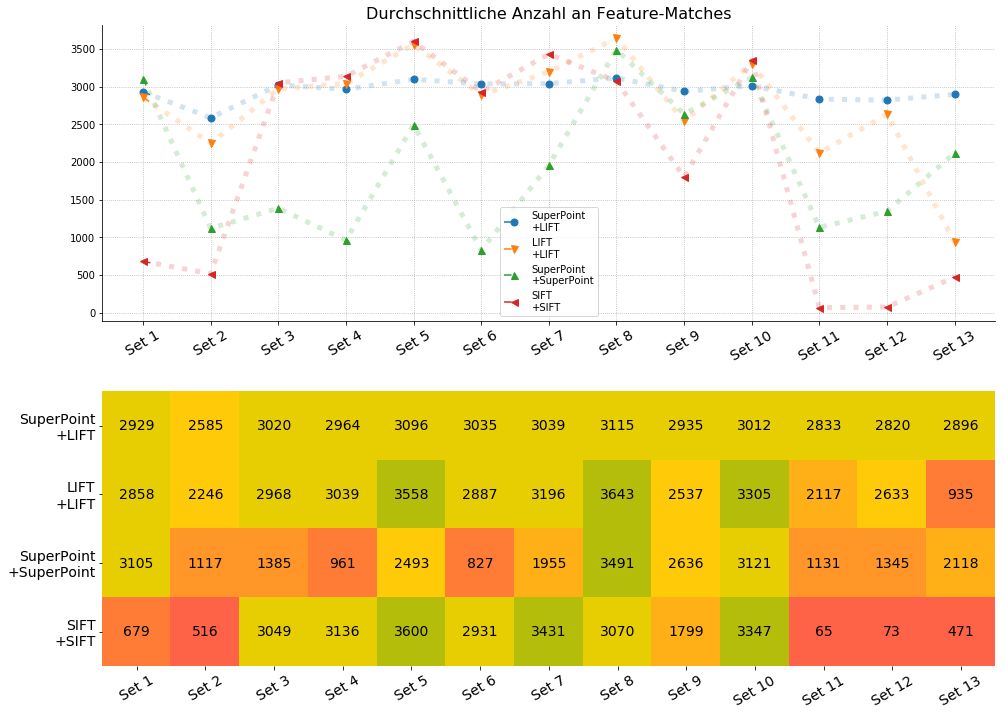

In [380]:
fig, _ = plot_stats2(data, dd_combinations, 'max_num_inliers', options_data={
   'convert_to': np.int,             
}, options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Durchschnittliche Anzahl an Feature-Matches'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names,
    'vmax': (1000 + 5000 + 10000) / 3,
    'value_formatter': '{}'
});
save_figure(outpath, 'avg_num_matches.png', fig)

### Num Inliers ist Teilmenge der Matches

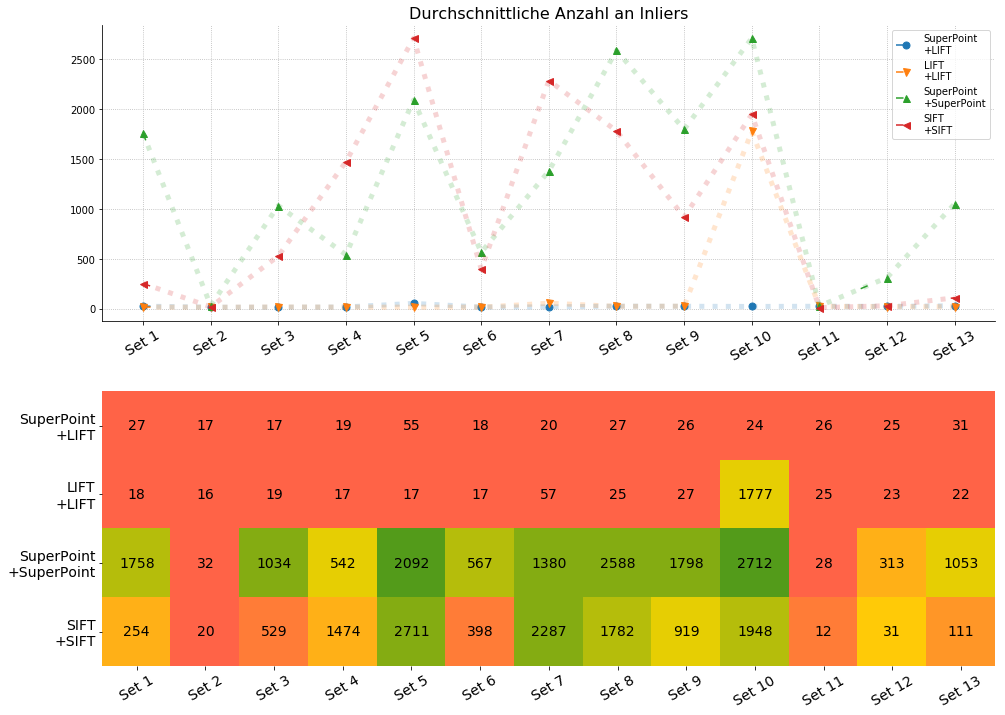

In [381]:
 _dn = []
for detector_name, descriptor_name in dd_combinations:
    _dn.append(data['inlier_ratio'].loc[detector_name, descriptor_name].values)
_dn = np.vstack(_dn)

fig, _ = plot_stats2(data, dd_combinations, 'num_inliers', options_data={
   'convert_to': np.int,             
}, options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Durchschnittliche Anzahl an Inliers'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names,
    'value_formatter': '{}',
    'data_normalized' : _dn
});
save_figure(outpath, 'avg_num_inliers.png', fig)

### Durchschnittsdistanz zu den Epipolarlinien

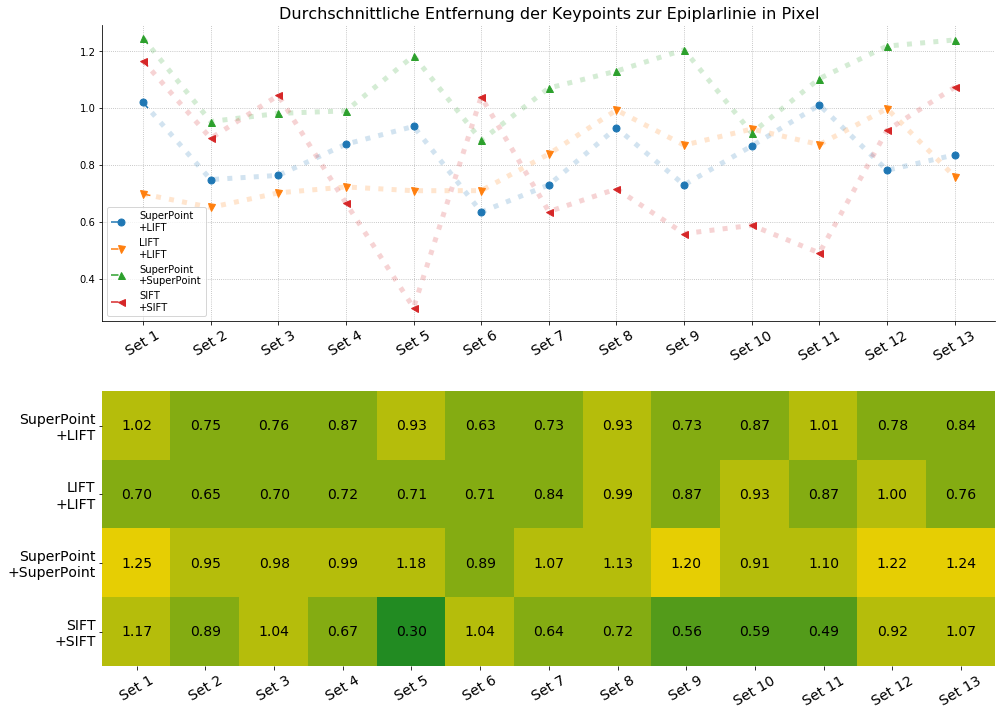

In [382]:
fig, _ = plot_stats2(data, dd_combinations, 'avg_distance', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Durchschnittliche Entfernung der Keypoints zur Epiplarlinie in Pixel'
}, options_rectplot={
    'cmap': cmap_bad,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names,
    'vmax': 3
});
save_figure(outpath, 'avg_distance_to_epilines_in_pixels.png', fig)

In [37]:
#plot_stats(data, dd_combinations, 'num_inliers', colorlist)
_d = data['num_inliers'] / data['max_num_inliers']
#plot_stats(data, dd_combinations, 'num_inliers', colorlist)
#plot_stats(_d, dd_combinations, 'num_inliers', colorlist)
_d

set_name                       v_set_01  v_set_02  v_set_03  v_set_04  \
detector_name descriptor_name                                           
lift          lift             0.006531  0.007123  0.006401  0.005813   
sift          sift             0.374203  0.040052  0.173500  0.469926   
superpoint    lift             0.009216  0.006704  0.005740  0.006410   
              superpoint       0.566123  0.028648  0.747052  0.564690   

set_name                       v_set_05  v_set_06  v_set_07  v_set_08  \
detector_name descriptor_name                                           
lift          lift             0.004871  0.006119  0.018040  0.007044   
sift          sift             0.753148  0.136017  0.666440  0.580610   
superpoint    lift             0.017978  0.006041  0.006580  0.008667   
              superpoint       0.839283  0.685058  0.706053  0.741526   

set_name                       v_set_09  v_set_10  v_set_11  v_set_12  \
detector_name descriptor_name                                           
lift          lift             0.010642  0.537818  0.011963  0.008986   
sift          sift             0.511115  0.582113  0.188776  0.424658   
superpoint    lift             0.009084  0.008188  0.009176  0.008863   
              superpoint       0.682134  0.868980  0.025339  0.232846   

set_name                       v_set_13  
detector_name descriptor_name            
lift          lift             0.023886  
sift          sift             0.236209  
superpoint    lift             0.010820  
              superpoint       0.497089

In [359]:
data['num_inliers']

set_name                          v_set_01   v_set_02     v_set_03  \
detector_name descriptor_name                                        
lift          lift               18.666667  16.000000    19.000000   
sift          sift              254.333333  20.666667   529.000000   
superpoint    lift               27.000000  17.333333    17.333333   
              superpoint       1758.000000  32.000000  1034.666667   

set_name                          v_set_04     v_set_05    v_set_06  \
detector_name descriptor_name                                         
lift          lift               17.666667    17.333333   17.666667   
sift          sift             1474.000000  2711.333333  398.666667   
superpoint    lift               19.000000    55.666667   18.333333   
              superpoint        542.666667  2092.333333  567.000000   

set_name                          v_set_07     v_set_08     v_set_09  \
detector_name descriptor_name                                          
lift          lift               57.666667    25.666667    27.000000   
sift          sift             2287.000000  1782.666667   919.666667   
superpoint    lift               20.000000    27.000000    26.666667   
              superpoint       1380.333333  2588.666667  1798.333333   

set_name                          v_set_10   v_set_11    v_set_12     v_set_13  
detector_name descriptor_name                                                   
lift          lift             1777.666667  25.333333   23.666667    22.333333  
sift          sift             1948.333333  12.333333   31.000000   111.333333  
superpoint    lift               24.666667  26.000000   25.000000    31.333333  
              superpoint       2712.666667  28.666667  313.333333  1053.000000

### Punktzahl

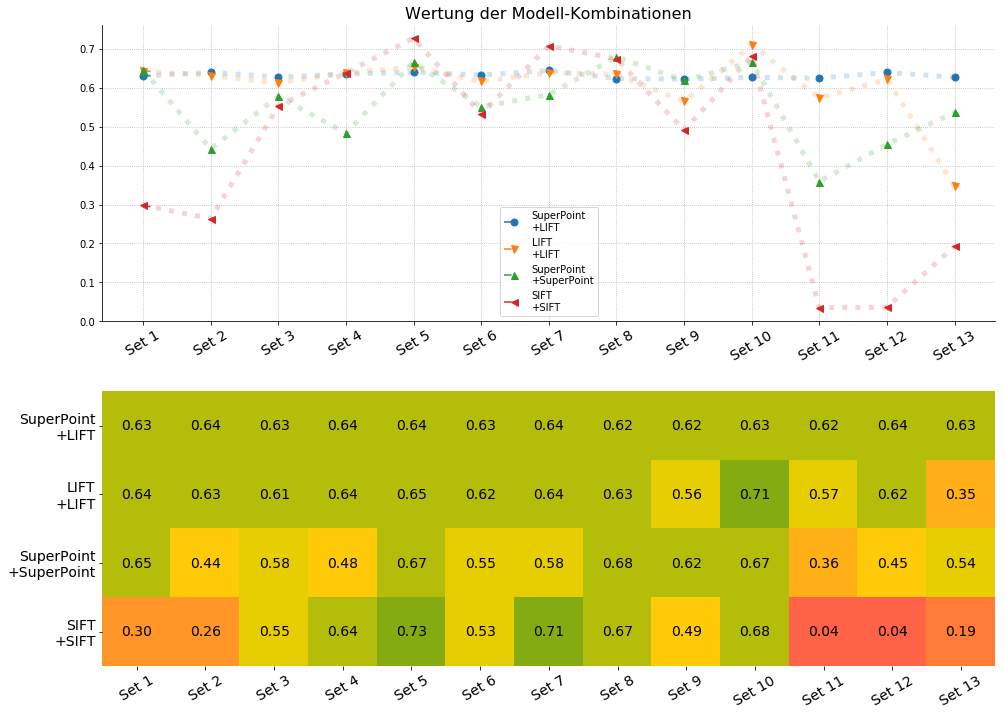

In [384]:
# def custom_score_function(row):
#     """ Gets a pandas dataframe row, evaluates score"""
    
#     R1 =  0.5 * np.tanh(row['matchability'])
#     A1 = np.tanh(row['accuracy_matches'] ** 2)
    
#     R2 = 0.5 * np.tanh(row['inlier_ratio'])
#     A2 = np.tanh(row['accuracy_inliers'])
    
#     score = 0.5 * row['lambda'] * (np.tanh(R1 + A1) + np.tanh(R2 + A2))
    
#     return score

scores = np.zeros((4, 13))
for idx, combo in enumerate(dd_combinations):
    b = np.vstack([
        data.loc[combo[0], combo[1]]['lambda'].values,
        data.loc[combo[0], combo[1]]['matchability'].values,
        data.loc[combo[0], combo[1]]['accuracy_matches'].values,
        data.loc[combo[0], combo[1]]['inlier_ratio'].values,
        data.loc[combo[0], combo[1]]['accuracy_inliers'].values
    ]).T


    r1 = 0.5 * np.tanh(b[:, 1])
    a1 = np.tanh(b[:, 2])
    r2 = 0.5 * np.tanh(b[:, 3])
    a2 = np.tanh(b[:, 4])

    s = 0.5 * b[:, 0] * (np.tanh(r1 + a1) + np.tanh(r2 + a2))
    scores[idx, : ] = s
    
fig, _ = plot_stats2(scores, dd_combinations, '', options_lineplot={
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'ylabel': '',
    'linelabels': dd_combination_names,
    'linewidth': 5,
    'linealpha': 0.2,
    'linemarkersize': 7,
    'title': r'Wertung der Modell-Kombinationen'
}, options_rectplot={
    'cmap': cmap_good,
    'xticks': np.arange(len(set_labels)),
    'xticklabels': set_labels,
    'yticks': np.arange(len(dd_combination_names)),
    'yticklabels': dd_combination_names
});
save_figure(outpath, 'scores.png', fig)